In [3]:
!pip install noisereduce
!pip install librosa



[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 1.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 5.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 5.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
# quick_process.py
from pathlib import Path

def quick_bulk_process(input_folder, output_folder=None):
    """
    One-line bulk processing for common use cases
    """
    if output_folder is None:
        output_folder = Path(input_folder) / 'processed'
    
    # Create processor
    processor = AudioBulkProcessor(target_sr=16000, n_jobs=1)
    
    # Process
    results = processor.process_directory(
        input_dir=input_folder,
        output_dir=output_folder,
        normalize=True,
        noise_reduce=True,
        remove_silence=True,
        norm_params={'method': 'peak', 'target_level': -1.0},
        noise_params={'method': 'spectral_gate', 'prop_decrease': 0.9},
        silence_params={'top_db': 25}
    )
    
    print(f"Processed {len([r for r in results if r[0]])} files")
    print(f"Output saved to: {output_folder}")
    
    return results

# Usage
if __name__ == '__main__':
    # Just change this path
    quick_bulk_process('Emotion Speech Dataset/')

Found 35000 audio files to process


Processing audio files: 100%|██████████| 35000/35000 [05:55<00:00, 98.44it/s] 


Processing Complete:
  Successful: 35000 files
  Failed: 0 files
Processed 35000 files
Output saved to: Emotion Speech Dataset/processed


### Feature Extraction

In [1]:
!pip install librosa pandas numpy h5py tqdm -q


[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [ ]:
# =====================
# 1. SETUP AND CONFIGURATION
# =====================

import os
import numpy as np
import pandas as pd
import librosa
import h5py
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
SAMPLE_RATE = 22050
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
TARGET_EMOTIONS = ['sad', 'happy', 'angry', 'surprise', 'neutral']

# --- EXISTING FOLDER-BASED DATASETS ---
DATASET_PATHS = {
    'jl-corpus': '/Users/omari/Master Classes/ML/jl-corpus/processed',
    'TESS': '/Users/omari/Master Classes/ML/TESS/processed',
    'ESD': '/Users/omari/Master Classes/ML/Emotion Speech Dataset/processed'
}

# --- NEW CSV-BASED DATASETS EXTENSION ---
# Configuration for the additional datasets (RAVDESS, SAVEE)
CSV_DATASETS = [
    {
        'path': 'ML - Combined Dataset (RAVDESS - SAVEE).csv',
        # Adjust this path to where the "ravdess-emotional-speech-audio" folder sits
        'base_dir': '/Users/omari/Master Classes/ML/' 
    }
]

# =====================
# 2. EMOTION MAPPING AND STANDARDIZATION
# =====================

# Comprehensive emotion mapping dictionary
EMOTION_MAPPING = {
    # Standard emotions (already correct)
    'sad': 'sad',
    'happy': 'happy',
    'angry': 'angry',
    'surprise': 'surprise',
    'neutral': 'neutral',
    
    # TESS specific variations
    'pleasant_surprise': 'surprise',
    'pleasant surprise': 'surprise',
    'ps': 'surprise',  # TESS abbreviation
    'fear': 'surprise',  # Map fear to surprise for consistency
    'disgust': 'angry',  # Map disgust to angry
    'fearful': 'surprise',
    'disgusted': 'angry',
    
    # Adjective/Noun variations
    'sadness': 'sad',
    'happiness': 'happy',
    'anger': 'angry',
    'surprised': 'surprise',
    
    # ESD variations
    'Surprise': 'surprise',
    'Angry': 'angry',
    'Happy': 'happy',
    'Sad': 'sad',
    'Neutral': 'neutral',
    
    # JL Corpus variations
    'SAD': 'sad',
    'HAPPY': 'happy',
    'ANGRY': 'angry',
    'SURPRISE': 'surprise',
    'NEUTRAL': 'neutral',
    
    # Additional common variations
    'joy': 'happy',
    'joyful': 'happy',
    'angryanger': 'angry',
    'neutralneutral': 'neutral',
}

def standardize_emotion(input_emotion, filename, dataset_name):
    """
    Standardize emotion names across all datasets
    """
    if not input_emotion:
        return None
    
    input_lower = str(input_emotion).lower().strip().replace(' ', '_')
    
    # Direct mapping first
    if input_lower in EMOTION_MAPPING:
        return EMOTION_MAPPING[input_lower]
    
    # Check for partial matches
    for key in EMOTION_MAPPING:
        if key in input_lower:
            return EMOTION_MAPPING[key]
    
    # Dataset-specific heuristics
    if dataset_name == 'TESS':
        # TESS patterns: OAF_back_angry.wav or YAF_back_sad.wav
        for emotion in TARGET_EMOTIONS:
            if f'_{emotion}' in filename.lower() or f'-{emotion}' in filename.lower():
                return emotion
    
    elif dataset_name == 'jl-corpus':
        # JL patterns: filename contains emotion
        for emotion in TARGET_EMOTIONS:
            if emotion in filename.lower():
                return emotion
    
    return None

def extract_emotion_from_path(file_path, dataset_name):
    """
    Extract emotion from file path based on dataset structure
    """
    filename = os.path.basename(file_path).lower()
    parent_dir = os.path.basename(os.path.dirname(file_path)).lower()
    
    emotion = None
    
    # 1. JL Corpus: Emotion in filename
    if dataset_name == 'jl-corpus':
        for target_emotion in TARGET_EMOTIONS:
            if target_emotion in filename:
                emotion = target_emotion
                break
    
    # 2. ESD: Emotion in folder name
    elif dataset_name == 'ESD':
        # ESD structure: .../Angry/001/... or .../Surprise/002/...
        for target_emotion in TARGET_EMOTIONS:
            if target_emotion in parent_dir:
                emotion = target_emotion
                break
    
    # 3. TESS: Both folder and filename contain emotion
    elif dataset_name == 'TESS':
        # Check folder first (TESS has emotion folders)
        folder_emotions = []
        for target_emotion in TARGET_EMOTIONS:
            if target_emotion in parent_dir:
                folder_emotions.append(target_emotion)
        
        # Check filename
        file_emotions = []
        for target_emotion in TARGET_EMOTIONS:
            if target_emotion in filename:
                file_emotions.append(target_emotion)
        
        # Prioritize folder emotion, fallback to filename
        if folder_emotions:
            emotion = folder_emotions[0]
        elif file_emotions:
            emotion = file_emotions[0]
        else:
            # Check for TESS specific patterns
            if 'ps'in filename or 'pleasant' in filename:
                emotion = 'surprise'
            elif 'fear' in filename or parent_dir:
                emotion = 'surprise'
            elif 'disgust' in filename or parent_dir:
                emotion = 'angry' 
    
    return emotion

# =====================
# 3. FEATURE EXTRACTION FUNCTIONS
# =====================

def extract_mfcc_features(audio_path, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    """
    Extract MFCC features from audio file
    """
    try:
        # Load audio
        audio, _ = librosa.load(audio_path, sr=sr, mono=True)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(
            y=audio, 
            sr=sr, 
            n_mfcc=n_mfcc,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH
        )
        
        # Transpose to get (time_steps, features)
        mfccs = mfccs.T
        
        # Pad/trim to fixed length (3 seconds at target sample rate)
        target_length = int(3 * sr / HOP_LENGTH)  # ~129 frames for 3s
        if mfccs.shape[0] > target_length:
            mfccs = mfccs[:target_length]
        else:
            padding = target_length - mfccs.shape[0]
            mfccs = np.pad(mfccs, ((0, padding), (0, 0)), mode='constant')
        
        return mfccs.astype(np.float32)
    
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# =====================
# MODIFIED CONFIGURATION
# =====================

# ... (Keep existing imports and DATASET_PATHS) ...

# Update this section for RAVDESS and SAVEE
CSV_DATASETS = [
    {
        'path': 'ML - Combined Dataset (RAVDESS - SAVEE).csv',
        'replacements': {
            # Format: "Prefix found in CSV" : "Your Local Directory Path"
            
            # 1. RAVDESS Mapping
            'ravdess-emotional-speech-audio/processed': '/Users/omari/Master Classes/ML/RAVDESS',
            
            # 2. SAVEE Mapping
            'surrey-audiovisual-expressed-emotion-savee/processed': '/Users/omari/Master Classes/ML/SAVEE'
        }
    }
]

# =====================
# MODIFIED CSV SCANNING FUNCTION
# =====================

def scan_csv_files(csv_configs):
    """
    Scan datasets defined in CSV files with dynamic path replacement
    """
    all_files = []
    
    for config in csv_configs:
        csv_path = config['path']
        replacements = config.get('replacements', {})
        
        if not os.path.exists(csv_path):
            print(f"⚠️ CSV file not found: {csv_path}")
            continue
            
        print(f"\n📄 Scanning CSV: {csv_path}...")
        try:
            df = pd.read_csv(csv_path)
            df.columns = df.columns.str.strip().str.lower()
        except Exception as e:
            print(f"   ❌ Error reading CSV: {e}")
            continue
            
        required_cols = ['filepath', 'dataset', 'emotion']
        if not all(col in df.columns for col in required_cols):
            print(f"   ❌ CSV missing required columns. Found: {list(df.columns)}")
            continue
            
        processed_count = 0
        skipped_count = 0
        missing_file_count = 0
        
        for _, row in tqdm(df.iterrows(), total=len(df), desc=f"  Processing CSV"):
            rel_path = str(row['filepath']).strip()
            raw_emotion = str(row['emotion']).strip()
            dataset_name = str(row['dataset']).strip()
            
            # --- DYNAMIC PATH REPLACEMENT LOGIC ---
            full_path = rel_path
            path_replaced = False
            
            # Check if the CSV path starts with any of our defined prefixes
            for prefix, replacement_dir in replacements.items():
                # We normalize slashes to ensure matching works on Windows/Mac
                clean_prefix = prefix.replace('\\', '/')
                clean_path = rel_path.replace('\\', '/')
                
                if clean_path.startswith(clean_prefix):
                    # Remove the prefix and join the remainder with the new local directory
                    # This handles cases where the prefix might not have a trailing slash
                    remainder = clean_path[len(clean_prefix):].lstrip('/')
                    full_path = os.path.join(replacement_dir, remainder)
                    path_replaced = True
                    break
            
            # If no replacement matched, warn (optional) or treat as absolute
            if not path_replaced and replacements:
                # Fallback: assume the path in CSV is absolute or relative to script
                pass
            # --------------------------------------

            # Standardize emotion
            standardized_emotion = standardize_emotion(
                raw_emotion, 
                os.path.basename(full_path), 
                dataset_name
            )
            
            if standardized_emotion not in TARGET_EMOTIONS:
                skipped_count += 1
                continue
                
            if not os.path.exists(full_path):
                missing_file_count += 1
                if missing_file_count <= 3:
                    print(f"   ⚠️ File not found: {full_path}")
                continue
                
            all_files.append({
                'file_path': full_path,
                'dataset': dataset_name,
                'raw_emotion': raw_emotion,
                'emotion': standardized_emotion,
                'filename': os.path.basename(full_path)
            })
            processed_count += 1
            
        print(f"   ✅ Processed: {processed_count}")
        print(f"   ❌ Skipped (emotion): {skipped_count}")
        print(f"   ⚠️ Missing files: {missing_file_count}")
        
    return all_files

# =====================
# 4. MAIN PROCESSING PIPELINE
# =====================

def create_unified_feature_file():
    """
    Main function to create unified feature file
    """
    print("=" * 60)
    print("🎵 UNIFIED FEATURE EXTRACTION PIPELINE")
    print("=" * 60)
    
    # Step 1: Scan and categorize all files
    print("\n📊 Step 1: Scanning datasets and standardizing emotions...")
    
    # A. Scan Folders (Original)
    folder_files = scan_audio_files(DATASET_PATHS)
    
    # B. Scan CSVs (New Extension)
    csv_files = scan_csv_files(CSV_DATASETS)
    
    # Combine lists
    all_files = folder_files + csv_files
    
    if not all_files:
        print("❌ No valid audio files found!")
        return None
    
    print(f"\n✅ Total valid files: {len(all_files)}")
    
    # Show emotion distribution
    emotion_counts = {}
    for file_info in all_files:
        emotion = file_info['emotion']
        emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
    
    print("\n📈 Emotion Distribution:")
    for emotion, count in sorted(emotion_counts.items()):
        print(f"  {emotion}: {count} files")
    
    # Step 2: Create HDF5 file for storage
    print("\n📁 Step 2: Creating unified feature file...")
    
    output_file = 'unified_audio_features.h5'
    
    with h5py.File(output_file, 'w') as hf:
        # Create datasets
        features_dset = hf.create_dataset(
            'features',
            shape=(0, int(3 * SAMPLE_RATE / HOP_LENGTH), N_MFCC),
            maxshape=(None, int(3 * SAMPLE_RATE / HOP_LENGTH), N_MFCC),
            dtype=np.float32,
            chunks=True,
            compression='gzip'
        )
        
        # Create datasets for metadata
        emotions_dset = hf.create_dataset(
            'emotions',
            shape=(0,),
            maxshape=(None,),
            dtype=h5py.string_dtype(encoding='utf-8')
        )
        
        filepaths_dset = hf.create_dataset(
            'filepaths',
            shape=(0,),
            maxshape=(None,),
            dtype=h5py.string_dtype(encoding='utf-8')
        )
        
        datasets_dset = hf.create_dataset(
            'datasets',
            shape=(0,),
            maxshape=(None,),
            dtype=h5py.string_dtype(encoding='utf-8')
        )
        
        # Step 3: Extract features and save
        print("\n⚡ Step 3: Extracting MFCC features...")
        
        successful = 0
        failed = 0
        
        for idx, file_info in enumerate(tqdm(all_files, desc="Extracting features")):
            try:
                # Extract features
                features = extract_mfcc_features(file_info['file_path'])
                
                if features is not None:
                    # Resize datasets
                    features_dset.resize(features_dset.shape[0] + 1, axis=0)
                    emotions_dset.resize(emotions_dset.shape[0] + 1, axis=0)
                    filepaths_dset.resize(filepaths_dset.shape[0] + 1, axis=0)
                    datasets_dset.resize(datasets_dset.shape[0] + 1, axis=0)
                    
                    # Add data
                    features_dset[-1] = features
                    emotions_dset[-1] = file_info['emotion']
                    filepaths_dset[-1] = file_info['file_path']
                    datasets_dset[-1] = file_info['dataset']
                    
                    successful += 1
                else:
                    failed += 1
                    
            except Exception as e:
                failed += 1
                continue
        
        # Save emotion encoding mapping
        emotion_to_idx = {emotion: i for i, emotion in enumerate(TARGET_EMOTIONS)}
        hf.attrs['emotion_encoding'] = str(emotion_to_idx)
        hf.attrs['sample_rate'] = SAMPLE_RATE
        hf.attrs['n_mfcc'] = N_MFCC
        hf.attrs['total_files'] = successful
    
    print(f"\n✅ Feature extraction complete!")
    print(f"   Successful: {successful} files")
    print(f"   Failed: {failed} files")
    print(f"   Output file: {output_file}")
    print(f"   File size: {os.path.getsize(output_file) / (1024**3):.2f} GB")
    
    # Create a summary CSV for easy reference
    print("\n📋 Creating summary CSV...")
    summary_data = []
    with h5py.File(output_file, 'r') as hf:
        for i in range(len(hf['emotions'])):
            summary_data.append({
                'filepath': hf['filepaths'][i].decode('utf-8'),
                'dataset': hf['datasets'][i].decode('utf-8'),
                'emotion': hf['emotions'][i].decode('utf-8'),
                'feature_index': i
            })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('features_summary.csv', index=False)
    
    print(f"✅ Summary saved to: features_summary.csv")
    
    return output_file

# =====================
# 5. LOADING UTILITIES
# =====================

def load_features_from_h5(file_path, emotion_filter=None):
    """
    Load features from HDF5 file with optional emotion filtering
    """
    features = []
    labels = []
    filepaths = []
    
    with h5py.File(file_path, 'r') as hf:
        total_files = hf.attrs['total_files']
        
        for i in range(total_files):
            emotion = hf['emotions'][i].decode('utf-8')
            
            # Apply emotion filter if specified
            if emotion_filter and emotion not in emotion_filter:
                continue
            
            features.append(hf['features'][i])
            labels.append(emotion)
            filepaths.append(hf['filepaths'][i].decode('utf-8'))
    
    return np.array(features), np.array(labels), filepaths

def get_dataset_info(file_path):
    """
    Get information about the stored features
    """
    with h5py.File(file_path, 'r') as hf:
        print("📊 Feature File Information:")
        print(f"   Total files: {hf.attrs['total_files']}")
        print(f"   Sample rate: {hf.attrs['sample_rate']}")
        print(f"   MFCC features: {hf.attrs['n_mfcc']}")
        
        # Count emotions
        emotions = [e.decode('utf-8') for e in hf['emotions'][:]]
        emotion_counts = {}
        for emotion in emotions:
            emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
        
        print("\n🎭 Emotion Distribution:")
        for emotion, count in sorted(emotion_counts.items()):
            print(f"   {emotion}: {count} files")
        
        # Show dataset distribution
        datasets = [d.decode('utf-8') for d in hf['datasets'][:]]
        dataset_counts = {}
        for dataset in datasets:
            dataset_counts[dataset] = dataset_counts.get(dataset, 0) + 1
        
        print("\n📁 Dataset Distribution:")
        for dataset, count in sorted(dataset_counts.items()):
            print(f"   {dataset}: {count} files")

# =====================
# 6. EXECUTION
# =====================

if __name__ == "__main__":
    # Run the feature extraction pipeline
    feature_file = create_unified_feature_file()
    
    if feature_file:
        # Display information about the created file
        get_dataset_info(feature_file)
        
        # Example: Load all features for training
        print("\n📥 Example: Loading features for model training...")
        features, labels, filepaths = load_features_from_h5(feature_file)
        
        print(f"Loaded {len(features)} feature vectors")
        print(f"Feature shape: {features[0].shape}")
        print(f"Labels: {np.unique(labels, return_counts=True)}")
        
        # Download from Colab
        print(f"\n💾 To download in Colab:")
        print("from google.colab import files")
        print("files.download('unified_audio_features.h5')")
        print("files.download('features_summary.csv')")

🎵 UNIFIED FEATURE EXTRACTION PIPELINE

📊 Step 1: Scanning datasets and standardizing emotions...

📁 Scanning jl-corpus...
   Found 12160 audio files


  Processing jl-corpus: 100%|██████████| 12160/12160 [00:00<00:00, 583882.69it/s]


   ✅ Processed: 5824, ❌ Skipped: 6336

📁 Scanning TESS...
   Found 5600 audio files


  Processing TESS: 100%|██████████| 5600/5600 [00:00<00:00, 319036.46it/s]

   ✅ Processed: 5600, ❌ Skipped: 0

📁 Scanning ESD...


   Found 35000 audio files


  Processing ESD: 100%|██████████| 35000/35000 [00:00<00:00, 603323.36it/s]


   ✅ Processed: 35000, ❌ Skipped: 0

📄 Scanning CSV: ML - Combined Dataset (RAVDESS - SAVEE).csv...


  Processing CSV: 100%|██████████| 1224/1224 [00:00<00:00, 40611.87it/s]


   ✅ Processed: 1224
   ❌ Skipped (emotion): 0
   ⚠️ Missing files: 0

✅ Total valid files: 47648

📈 Emotion Distribution:
  angry: 9508 files
  happy: 9508 files
  neutral: 9472 files
  sad: 9508 files
  surprise: 9652 files

📁 Step 2: Creating unified feature file...

⚡ Step 3: Extracting MFCC features...


Extracting features: 100%|██████████| 47648/47648 [19:25<00:00, 40.90it/s]



✅ Feature extraction complete!
   Successful: 47648 files
   Failed: 0 files
   Output file: unified_audio_features.h5
   File size: 0.21 GB

📋 Creating summary CSV...
✅ Summary saved to: features_summary.csv
📊 Feature File Information:
   Total files: 47648
   Sample rate: 22050
   MFCC features: 13

🎭 Emotion Distribution:
   angry: 9508 files
   happy: 9508 files
   neutral: 9472 files
   sad: 9508 files
   surprise: 9652 files

📁 Dataset Distribution:
   ESD: 35000 files
   RAVDESS: 864 files
   SAVEE: 360 files
   TESS: 5600 files
   jl-corpus: 5824 files

📥 Example: Loading features for model training...
Loaded 47648 feature vectors
Feature shape: (129, 13)
Labels: (array(['angry', 'happy', 'neutral', 'sad', 'surprise'], dtype='<U8'), array([9508, 9508, 9472, 9508, 9652]))

💾 To download in Colab:
from google.colab import files
files.download('unified_audio_features.h5')
files.download('features_summary.csv')


In [6]:
# HYPERPARAMETER CONFIGURATION
HYPERPARAMS = {
    # Optimizer (Adam is most popular in SER research)
    'optimizer': 'adam',
    'learning_rate': 0.001,  # Most common initial LR
    'beta_1': 0.9,           # Adam default
    'beta_2': 0.999,         # Adam default
    'epsilon': 1e-7,
    
    # Loss function (Categorical Crossentropy for multi-class)
    'loss': 'categorical_crossentropy',
    
    # Metrics
    'metrics': ['accuracy', 'categorical_accuracy'],
    
    # Training
    'batch_size': 64,        # Popular: 32, 64, 128 (64 works well for 46K samples)
    'epochs': 100,           # Use early stopping
    
    # Regularization
    'l2_regularization': 0.001,  # Common weight decay
    
    # Learning rate scheduling
    'lr_patience': 5,        # Reduce LR when plateau
    'lr_factor': 0.5,        # Reduce by half
    
    # Early stopping
    'early_stop_patience': 15,
}

def configure_model_for_training(model, hyperparams):
    """
    Configure model with research-backed hyperparameters
    """
    # Adam optimizer with recommended settings
    optimizer = keras.optimizers.Adam(
        learning_rate=hyperparams['learning_rate'],
        beta_1=hyperparams['beta_1'],
        beta_2=hyperparams['beta_2'],
        epsilon=hyperparams['epsilon']
    )
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=hyperparams['loss'],
        metrics=hyperparams['metrics']
    )
    
    return model

# Configure the model
model = configure_model_for_training(model, HYPERPARAMS)

🚀 STARTING BASIC CNN TRAINING (Keras 3 Compatible)
📥 Loading your real audio features...
   ✅ Loaded 47648 feature matrices
   ✅ Loaded 47648 emotion labels
   📊 Final Data Shape: (47648, 129, 13, 1)

🎭 Emotion Distribution:
   - angry: 9508
   - happy: 9508
   - neutral: 9472
   - sad: 9508
   - surprise: 9652

✂️  Splitting data (80% Train, 20% Test)...
   Train shape: (38118, 129, 13, 1)
   Test shape:  (9530, 129, 13, 1)

🏗️  Creating Basic CNN Model...
   ✅ Using Standard Adam Optimizer (Keras 3)


Model: "Basic_CNN_M1_Fixed"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 129, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 129, 13, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 6, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,941 (640.39 KB)

 Trainable params: 163,941 (640.39 KB)

 Non-trainable params: 0 (0.00 B)


⚖️  Calculating class weights...

🔥 Training Started...
Epoch 1/80
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2670 - loss: 1.7600
Epoch 1: val_accuracy improved from -inf to 0.46139, saving model to basic_cnn_best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 55s 90ms/step - accuracy: 0.2670 - loss: 1.7595 - val_accuracy: 0.4614 - val_loss: 1.3132 - learning_rate: 5.0000e-04
Epoch 2/80
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4143 - loss: 1.3233
Epoch 2: val_accuracy improved from 0.46139 to 0.54974, saving model to basic_cnn_best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 53s 90ms/step - accuracy: 0.4143 - loss: 1.3233 - val_accuracy: 0.5497 - val_loss: 1.0802 - learning_rate: 5.0000e-04
Epoch 3/80
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5044 - loss: 1.1622
Epoch 3: val_accuracy improved from 0.54974 to 0.58447, saving model to basic_cnn_best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 202s 340ms/step - accuracy: 0.5044 - loss: 1.1621 - val_accuracy

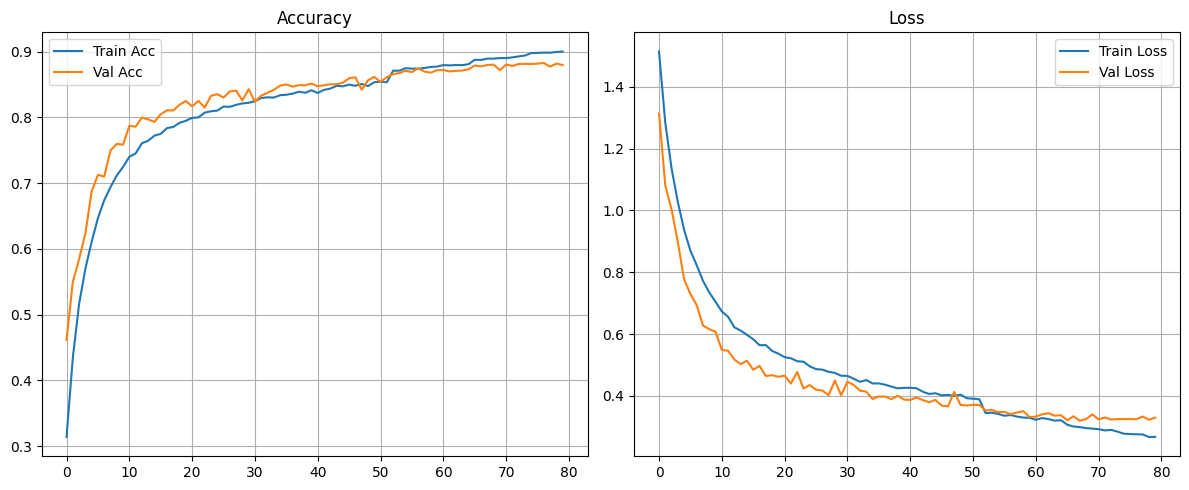

In [24]:
# =====================
# FIXED BASIC CNN TRAINING PIPELINE (Keras 3 + Mac M1/M2 Compatible)
# =====================

import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

# Set random seed for reproducibility
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# =====================
# 1. LOAD DATA
# =====================

def load_real_data(features_file='unified_audio_features.h5'):
    """
    Load actual MFCC features and labels from H5 file
    """
    print("📥 Loading your real audio features...")
    
    if not os.path.exists(features_file):
        raise FileNotFoundError(f"❌ File {features_file} not found! Please run feature extraction first.")

    with h5py.File(features_file, 'r') as hf:
        # Load features
        features = hf['features'][:]
        print(f"   ✅ Loaded {len(features)} feature matrices")
        
        # Load emotions
        emotions = [e.decode('utf-8') for e in hf['emotions'][:]]
        print(f"   ✅ Loaded {len(emotions)} emotion labels")
        
        # Load filepaths
        filepaths = [f.decode('utf-8') for f in hf['filepaths'][:]]
    
    # CNN REQUIREMENT: Shape must be (Batch, Height, Width, Channels)
    # Current: (46424, 129, 13)
    # Target:  (46424, 129, 13, 1)
    features = np.expand_dims(features, axis=-1)
    print(f"   📊 Final Data Shape: {features.shape}")
    
    # Encode emotions
    label_encoder = LabelEncoder()
    emotion_labels = label_encoder.fit_transform(emotions)
    onehot_labels = keras.utils.to_categorical(emotion_labels, 5)
    
    # Print Distribution
    print(f"\n🎭 Emotion Distribution:")
    unique, counts = np.unique(emotions, return_counts=True)
    for emotion, count in zip(unique, counts):
        print(f"   - {emotion}: {count}")
    
    return features, onehot_labels, label_encoder, filepaths

# =====================
# 2. DEFINE BASIC CNN MODEL (M1 FIXED)
# =====================

def create_basic_cnn_model(input_shape, num_classes):
    """
    Basic CNN Architecture adjusted for Mac M1/M2 stability.
    REMOVED BatchNormalization layers to fix 'Incompatible shapes' error.
    INCREASED Dropout to compensate for lack of BN regularization.
    """
    model = keras.Sequential(name="Basic_CNN_M1_Fixed")
    
    model.add(layers.Input(shape=input_shape))
    
    # --- Conv Block 1 ---
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Increased from 0.15
    
    # --- Conv Block 2 ---
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))   # Increased from 0.2
    
    # --- Conv Block 3 (Optional extra depth) ---
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    # --- Global Pooling ---
    model.add(layers.GlobalAveragePooling2D())
    
    # --- Dense Layers ---
    model.add(layers.Dense(128, activation='relu'))
    # BatchNormalization REMOVED
    model.add(layers.Dropout(0.4))   # Increased from 0.3
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))
    
    # --- Output ---
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# =====================
# 3. MAIN TRAINING PIPELINE
# =====================

def run_training_pipeline():
    print("=" * 60)
    print("🚀 STARTING BASIC CNN TRAINING (Keras 3 Compatible)")
    print("=" * 60)
    
    # 1. Load Data
    try:
        X, y, label_encoder, filepaths = load_real_data()
    except Exception as e:
        print(f"❌ Critical Error: {e}")
        return

    # 2. Split Data (Stratified)
    print("\n✂️  Splitting data (80% Train, 20% Test)...")
    y_integers = np.argmax(y, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_integers
    )
    print(f"   Train shape: {X_train.shape}")
    print(f"   Test shape:  {X_test.shape}")
    
    # 3. Create Model
    print("\n🏗️  Creating Basic CNN Model...")
    model = create_basic_cnn_model(input_shape=X_train.shape[1:], num_classes=5)
    
    # OPTIMIZER FIX: Use standard Adam (legacy is removed in Keras 3)
    # Since we removed BatchNormalization, standard Adam is safe on M1.
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    print("   ✅ Using Standard Adam Optimizer (Keras 3)")

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    
    # 4. Class Weights
    print("\n⚖️  Calculating class weights...")
    train_labels_int = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(train_labels_int), 
        y=train_labels_int
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    # 5. Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy', patience=12, restore_best_weights=True, verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'basic_cnn_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1
        ),
        keras.callbacks.CSVLogger('training_history_cnn.csv')
    ]
    
    # 6. Train
    print("\n🔥 Training Started...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=80,
        batch_size=64,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # =====================
    # 4. FINAL EVALUATION
    # =====================
    print("\n" + "="*40)
    print("📊 FINAL EVALUATION")
    print("="*40)
    
    # Load Best Model
    print("📥 Loading best saved model...")
    best_model = keras.models.load_model('basic_cnn_best_model.keras')
    
    # Get Predictions
    print("⚡ Generating predictions on Test Set...")
    y_pred_probs = best_model.predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Calculate Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n✅ Overall Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"✅ Weighted Precision: {prec:.4f}")
    print(f"✅ Weighted Recall:    {rec:.4f}")
    print(f"✅ Weighted F1-Score:  {f1:.4f}")
    
    print("\n📋 CLASSIFICATION REPORT")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    print("\n📉 CONFUSION MATRIX")
    print("-" * 60)
    print(confusion_matrix(y_true, y_pred))
    
    # Save Results
    results_df = pd.DataFrame({
        'filepath': [filepaths[i] for i in range(len(X_test))],
        'true_emotion': label_encoder.inverse_transform(y_true),
        'predicted_emotion': label_encoder.inverse_transform(y_pred),
        'confidence': np.max(y_pred_probs, axis=1)
    })
    results_df.to_csv('basic_cnn_predictions.csv', index=False)
    print(f"\n💾 Predictions saved to 'basic_cnn_predictions.csv'")

    # Plot History
    print("\n📈 Plotting History...")
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('cnn_training_history.png')
    plt.show()

if __name__ == "__main__":
    run_training_pipeline()

### CRNN (CNN + LSTM layer)

In [ ]:
# =====================
# CRNN TRAINING PIPELINE FOR SER
# =====================

import numpy as np
import pandas as pd
import h5py
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# =====================
# 1. LOAD DATA
# =====================

def load_real_data(features_file='unified_audio_features.h5'):
    """
    Load your actual 46K MFCC features and labels
    """
    print("📥 Loading your real audio features...")
    
    with h5py.File(features_file, 'r') as hf:
        # Load features
        features = hf['features'][:]
        print(f"✅ Loaded {len(features)} feature matrices")
        
        # Load emotions
        emotions = [e.decode('utf-8') for e in hf['emotions'][:]]
        print(f"✅ Loaded {len(emotions)} emotion labels")
        
        # Load filepaths for reference
        filepaths = [f.decode('utf-8') for f in hf['filepaths'][:]]
        
        # Check shapes
        # Expected shape from H5: (N_samples, TimeSteps, N_MFCC) e.g., (46424, 129, 13)
        print(f"\n📊 Data Shapes:")
        print(f"  Features: {features.shape}") 
    
    # CRNN requires shape: (Batch, Time, Features, Channels)
    # The 'Time' dimension must be preserved for LSTM. 
    # Current: (N, 129, 13) -> Add channel: (N, 129, 13, 1)
    features = np.expand_dims(features, axis=-1)
    print(f"  After adding channel: {features.shape}")
    
    # Encode emotions
    label_encoder = LabelEncoder()
    emotion_labels = label_encoder.fit_transform(emotions)
    
    # One-hot encoding
    onehot_labels = keras.utils.to_categorical(emotion_labels, 5)
    
    print(f"\n🎭 Emotion Distribution:")
    unique, counts = np.unique(emotions, return_counts=True)
    for emotion, count in zip(unique, counts):
        print(f"  {emotion}: {count} samples")
    
    return features, onehot_labels, label_encoder, filepaths

# =====================
# 2. CREATE CRNN MODEL
# =====================

def create_crnn_model(input_shape, num_classes):
    """
    Creates a CRNN (Convolutional Recurrent Neural Network)
    CNN extracts spatial features from MFCCs
    LSTM captures temporal context of those features
    """
    model = keras.Sequential()
    
    # --- CNN BLOCK (Feature Extractor) ---
    # Input Shape: (129, 13, 1) -> (Time, Freq, Channel)
    
    # Conv Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    # Pool only Frequency axis (axis 2), preserve Time (axis 1) slightly
    # (2, 1) means downsample Time by 2, Frequency by 1 (keep frequency resolution high)
    # OR standard (2,2) to reduce both. Let's use (2,2) for standard reduction.
    model.add(layers.MaxPooling2D(pool_size=(2, 2))) 
    model.add(layers.Dropout(0.2))
    
    # Conv Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))
    
    # Conv Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))

    # --- RECURRENT BLOCK (Temporal Context) ---
    
    # Current Shape: (Batch, Reduced_Time, Reduced_Freq, Filters)
    # We need to reshape for LSTM: (Batch, Time, Features)
    
    # TimeDistributed(Flatten) collapses (Freq * Filters) into one vector per time step
    model.add(layers.TimeDistributed(layers.Flatten()))
    
    # LSTM Layer
    # Returns only the final state (return_sequences=False) for classification
    model.add(layers.LSTM(128, return_sequences=False))
    model.add(layers.Dropout(0.3))
    
    # --- CLASSIFICATION BLOCK ---
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# =====================
# 3. TRAINING PIPELINE
# =====================

def train_on_real_data():
    print("=" * 60)
    print("🎵 TRAINING CRNN (CNN + LSTM) ON REAL DATA")
    print("=" * 60)
    
    # 1. Load Data
    X, y, label_encoder, filepaths = load_real_data()
    
    # 2. Split Data
    print("\n📊 Step 2: Splitting data (80% train, 20% test)...")
    y_integers = np.argmax(y, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_integers
    )
    
    # 3. Create CRNN Model 
    print("\n🏗️  Step 3: Creating CRNN model...")
    model = create_crnn_model(input_shape=X_train.shape[1:], num_classes=5)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    
    # 4. Class Weights
    print("\n⚖️  Step 4: Calculating class weights...")
    train_labels_int = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_int), y=train_labels_int)
    class_weight_dict = dict(enumerate(class_weights))
    
    # 5. Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
        keras.callbacks.ModelCheckpoint('crnn_best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
        keras.callbacks.CSVLogger('training_history_crnn.csv')
    ]
    
    # 6. Train
    print("\n🚀 Step 6: Training CRNN...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=80,  # CRNNs might converge faster or need fewer epochs than pure CNNs
        batch_size=64,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # 7. Evaluate
    print("\n📊 Step 7: Evaluating final model...")
    best_model = keras.models.load_model('crnn_best_model.keras')
    test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"   Test Accuracy: {test_acc:.4f}")
    
    # 8. Save Predictions
    print("\n💾 Step 8: Saving predictions...")
    y_pred = np.argmax(best_model.predict(X_test, verbose=0), axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    results_df = pd.DataFrame({
        'true_emotion': label_encoder.inverse_transform(y_true),
        'predicted_emotion': label_encoder.inverse_transform(y_pred)
    })
    results_df.to_csv('crnn_predictions.csv', index=False)
    
    # 9. Plot History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('CRNN Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('CRNN Loss')
    plt.legend()
    
    plt.savefig('crnn_training_plot.png')
    plt.show()
    
    return best_model, history

if __name__ == "__main__":
    train_on_real_data()

🎵 TRAINING CRNN (CNN + LSTM) ON REAL DATA
📥 Loading your real audio features...
✅ Loaded 47648 feature matrices
✅ Loaded 47648 emotion labels

📊 Data Shapes:
  Features: (47648, 129, 13)
  After adding channel: (47648, 129, 13, 1)

🎭 Emotion Distribution:
  angry: 9508 samples
  happy: 9508 samples
  neutral: 9472 samples
  sad: 9508 samples
  surprise: 9652 samples

📊 Step 2: Splitting data (80% train, 20% test)...

🏗️  Step 3: Creating CRNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 129, 13, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 129, 13, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 6, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 6, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 3, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 3, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 3, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 3, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 256)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 577,413 (2.20 MB)

 Trainable params: 576,389 (2.20 MB)

 Non-trainable params: 1,024 (4.00 KB)


⚖️  Step 4: Calculating class weights...

🚀 Step 6: Training CRNN...
Epoch 1/80
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3232 - loss: 1.6907
Epoch 1: val_accuracy improved from -inf to 0.47156, saving model to crnn_best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 97s 160ms/step - accuracy: 0.3233 - loss: 1.6904 - val_accuracy: 0.4716 - val_loss: 1.2342 - learning_rate: 5.0000e-04
Epoch 2/80
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.4717 - loss: 1.2430
Epoch 2: val_accuracy improved from 0.47156 to 0.54460, saving model to crnn_best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 97s 163ms/step - accuracy: 0.4718 - loss: 1.2429 - val_accuracy: 0.5446 - val_loss: 1.0803 - learning_rate: 5.0000e-04
Epoch 3/80
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.5671 - loss: 1.0455
Epoch 3: val_accuracy improved from 0.54460 to 0.64701, saving model to crnn_best_model.keras
596/596 ━━━━━━━━━━━━━━━━━━━━ 98s 164ms/step - accuracy: 0.5671 - loss: 1.0454 - val_accurac

AttributeError: module 'tensorflow' has no attribute 'DataFrame'

🔄 Resuming pipeline from Evaluation Phase (Skipping Training)...
✅ Data reloaded. Test set size: 9530
📥 Loading saved model...

📊 Evaluating model performance...
298/298 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9144 - loss: 0.3386
   Final Test Accuracy: 0.9153

💾 Generating predictions CSV...
✅ Saved to 'crnn_predictions.csv'

📈 Plotting training history from logs...


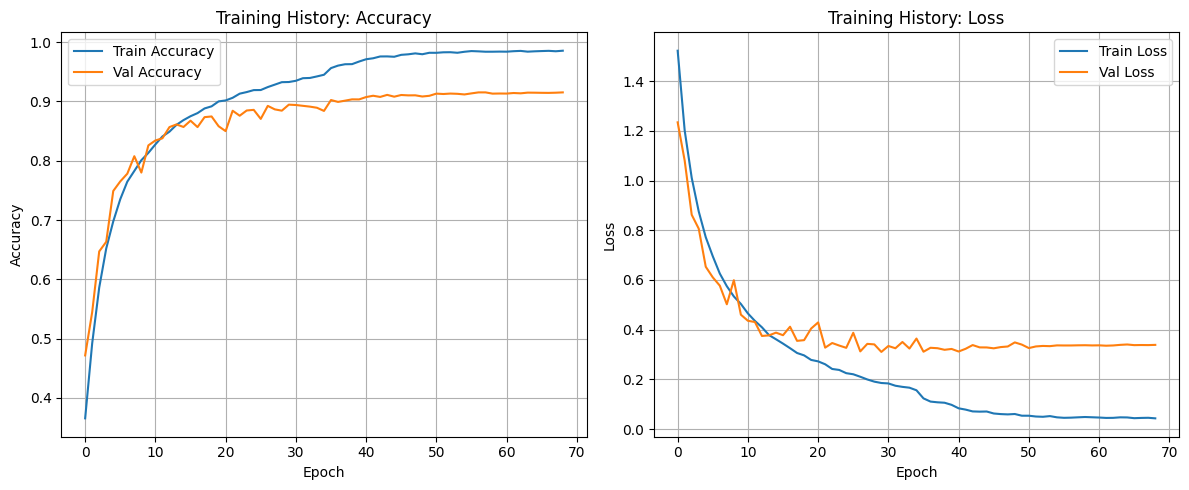

✅ Plot saved to 'crnn_training_plot.png'


In [21]:
# =====================
# CONTINUATION SCRIPT (NO RETRAINING)
# =====================

import os
import numpy as np
import pandas as pd  # <--- Correct import
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import h5py

# Re-define the load function needed to get X_test/y_test back
def load_real_data(features_file='unified_audio_features.h5'):
    with h5py.File(features_file, 'r') as hf:
        features = hf['features'][:]
        emotions = [e.decode('utf-8') for e in hf['emotions'][:]]
    
    # Expand dims for channel
    features = np.expand_dims(features, axis=-1)
    
    # Re-encode labels
    label_encoder = LabelEncoder()
    emotion_labels = label_encoder.fit_transform(emotions)
    onehot_labels = keras.utils.to_categorical(emotion_labels, 5)
    
    return features, onehot_labels, label_encoder

def continue_evaluation_only():
    print("🔄 Resuming pipeline from Evaluation Phase (Skipping Training)...")
    
    # 1. Reload Data (Fast)
    # We need X_test and y_test to be exactly the same as during training
    # So we use the SAME random_state=42
    X, y, label_encoder = load_real_data()
    
    y_integers = np.argmax(y, axis=1)
    _, X_test, _, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_integers
    )
    print(f"✅ Data reloaded. Test set size: {len(X_test)}")

    # 2. Load the Best Saved Model
    if not os.path.exists('crnn_best_model.keras'):
        print("❌ Error: 'crnn_best_model.keras' not found. Did the training finish?")
        return

    print("📥 Loading saved model...")
    best_model = keras.models.load_model('crnn_best_model.keras')
    
    # 3. Evaluate
    print("\n📊 Evaluating model performance...")
    test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
    print(f"   Final Test Accuracy: {test_acc:.4f}")
    
    # 4. Generate Predictions
    print("\n💾 Generating predictions CSV...")
    y_pred_probs = best_model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # This is the part that failed previously
    results_df = pd.DataFrame({
        'true_emotion': label_encoder.inverse_transform(y_true),
        'predicted_emotion': label_encoder.inverse_transform(y_pred),
        'confidence': np.max(y_pred_probs, axis=1)
    })
    results_df.to_csv('crnn_predictions.csv', index=False)
    print("✅ Saved to 'crnn_predictions.csv'")
    
    # 5. Plot History from CSV Log
    # Since the 'history' object is lost, we read the CSV log file created during training
    if os.path.exists('training_history_crnn.csv'):
        print("\n📈 Plotting training history from logs...")
        history_df = pd.read_csv('training_history_crnn.csv')
        
        plt.figure(figsize=(12, 5))
        
        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history_df['accuracy'], label='Train Accuracy')
        plt.plot(history_df['val_accuracy'], label='Val Accuracy')
        plt.title('Training History: Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        
        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history_df['loss'], label='Train Loss')
        plt.plot(history_df['val_loss'], label='Val Loss')
        plt.title('Training History: Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('crnn_training_plot.png')
        plt.show()
        print("✅ Plot saved to 'crnn_training_plot.png'")
    else:
        print("⚠️ 'training_history_crnn.csv' not found, skipping plots.")

if __name__ == "__main__":
    continue_evaluation_only()

In [22]:
# =====================
# CONTINUATION SCRIPT WITH FULL METRICS
# =====================

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import h5py

# --- Re-define Load Function ---
def load_real_data(features_file='unified_audio_features.h5'):
    with h5py.File(features_file, 'r') as hf:
        features = hf['features'][:]
        emotions = [e.decode('utf-8') for e in hf['emotions'][:]]
    
    # Expand dims for channel
    features = np.expand_dims(features, axis=-1)
    
    # Re-encode labels
    label_encoder = LabelEncoder()
    emotion_labels = label_encoder.fit_transform(emotions)
    onehot_labels = keras.utils.to_categorical(emotion_labels, 5)
    
    return features, onehot_labels, label_encoder

def continue_evaluation_with_metrics():
    print("🔄 Resuming pipeline for Detailed Evaluation...")
    
    # 1. Reload Data
    print("📥 Loading data...")
    X, y, label_encoder = load_real_data()
    
    y_integers = np.argmax(y, axis=1)
    _, X_test, _, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_integers
    )
    
    # 2. Load Model
    if not os.path.exists('crnn_best_model.keras'):
        print("❌ Error: 'crnn_best_model.keras' not found.")
        return

    print("🧠 Loading saved model...")
    best_model = keras.models.load_model('crnn_best_model.keras')
    
    # 3. Generate Predictions
    print("\n⚡ Generating predictions...")
    y_pred_probs = best_model.predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # 4. Calculate Comprehensive Metrics
    print("\n" + "="*40)
    print("📊 FINAL EVALUATION METRICS")
    print("="*40)
    
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # Precision, Recall, F1 (Weighted average accounts for class imbalance)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"✅ Overall Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"✅ Weighted Precision: {prec:.4f}")
    print(f"✅ Weighted Recall:    {rec:.4f}")
    print(f"✅ Weighted F1-Score:  {f1:.4f}")
    
    print("\n📋 DETAILED CLASSIFICATION REPORT")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    print("\n📉 CONFUSION MATRIX")
    print("-" * 60)
    print(confusion_matrix(y_true, y_pred))
    
    # 5. Save Results
    results_df = pd.DataFrame({
        'true_emotion': label_encoder.inverse_transform(y_true),
        'predicted_emotion': label_encoder.inverse_transform(y_pred),
        'confidence': np.max(y_pred_probs, axis=1)
    })
    results_df.to_csv('crnn_predictions_full.csv', index=False)
    print(f"\n💾 Predictions saved to 'crnn_predictions_full.csv'")

if __name__ == "__main__":
    continue_evaluation_with_metrics()

🔄 Resuming pipeline for Detailed Evaluation...
📥 Loading data...
🧠 Loading saved model...

⚡ Generating predictions...
298/298 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

📊 FINAL EVALUATION METRICS
✅ Overall Accuracy:  0.9153 (91.53%)
✅ Weighted Precision: 0.9152
✅ Weighted Recall:    0.9153
✅ Weighted F1-Score:  0.9153

📋 DETAILED CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

       angry       0.92      0.91      0.91      1902
       happy       0.87      0.87      0.87      1902
     neutral       0.94      0.94      0.94      1894
         sad       0.94      0.95      0.95      1902
    surprise       0.91      0.91      0.91      1930

    accuracy                           0.92      9530
   macro avg       0.92      0.92      0.92      9530
weighted avg       0.92      0.92      0.92      9530


📉 CONFUSION MATRIX
------------------------------------------------------------
[[1726   86   26   10 

In [28]:
# ==========================================
# STRATEGY C: REGULARIZED GRU + ROBUST SPECAUGMENT
# ==========================================

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

# ==========================================
# 1. DATA LOADING
# ==========================================
def load_real_data(features_file='unified_audio_features.h5'):
    print(f"📥 Loading data from {features_file}...")
    
    if not os.path.exists(features_file):
        raise FileNotFoundError(f"❌ Error: File '{features_file}' not found.")

    with h5py.File(features_file, 'r') as hf:
        features = hf['features'][:]
        emotions = [e.decode('utf-8') for e in hf['emotions'][:]]
    
    # Expand dims for channel (e.g., 128, 128) -> (128, 128, 1)
    features = np.expand_dims(features, axis=-1)
    
    # Re-encode labels
    label_encoder = LabelEncoder()
    emotion_labels = label_encoder.fit_transform(emotions)
    num_classes = len(np.unique(emotion_labels))
    onehot_labels = keras.utils.to_categorical(emotion_labels, num_classes)
    
    print(f"✅ Data Loaded: {features.shape} samples")
    return features, onehot_labels, label_encoder, num_classes

# ==========================================
# 2. ROBUST SPECAUGMENT IMPLEMENTATION
# ==========================================
def spec_augment(spectrogram, num_freq_masks=2, num_time_masks=2, freq_mask_param=15, time_mask_param=20):
    """
    Applies SpecAugment with safety checks for small dimensions.
    """
    aug_spectrogram = tf.identity(spectrogram)
    shape = tf.shape(aug_spectrogram)
    height = shape[0]
    width = shape[1]
    
    # Cast params to int32
    freq_mask_param = tf.cast(freq_mask_param, tf.int32)
    time_mask_param = tf.cast(time_mask_param, tf.int32)
    
    # --- Frequency Masking ---
    for _ in range(num_freq_masks):
        # 🛡️ SAFETY FIX: Ensure mask height is never larger than image height - 1
        # If image is 13px high, mask can be at most 12px.
        safe_f_max = tf.maximum(1, tf.minimum(freq_mask_param, height - 1))
        
        f = tf.random.uniform([], minval=0, maxval=safe_f_max, dtype=tf.int32)
        f0 = tf.random.uniform([], minval=0, maxval=height - f, dtype=tf.int32)
        
        mask_start = f0
        mask_end = f0 + f
        indices = tf.range(height)
        mask = (indices < mask_start) | (indices >= mask_end)
        mask = tf.reshape(mask, (height, 1, 1))
        mask = tf.cast(mask, aug_spectrogram.dtype)
        aug_spectrogram = aug_spectrogram * mask

    # --- Time Masking ---
    for _ in range(num_time_masks):
        # 🛡️ SAFETY FIX: Ensure mask width is never larger than image width - 1
        safe_t_max = tf.maximum(1, tf.minimum(time_mask_param, width - 1))
        
        t = tf.random.uniform([], minval=0, maxval=safe_t_max, dtype=tf.int32)
        t0 = tf.random.uniform([], minval=0, maxval=width - t, dtype=tf.int32)
        
        mask_start = t0
        mask_end = t0 + t
        indices = tf.range(width)
        mask = (indices < mask_start) | (indices >= mask_end)
        mask = tf.reshape(mask, (1, width, 1))
        mask = tf.cast(mask, aug_spectrogram.dtype)
        aug_spectrogram = aug_spectrogram * mask

    return aug_spectrogram

def apply_spec_augment_wrapper(image, label):
    # Wrapper for tf.data pipeline
    return spec_augment(image), label

# ==========================================
# 3. REGULARIZED CRNN ARCHITECTURE
# ==========================================
def build_regularized_crnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # --- CNN Block (Feature Extraction) ---
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x) 

    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # --- Bridge to RNN ---
    # Permute to (Batch, Time, Freq, Channels)
    x = layers.Permute((2, 1, 3))(x) 
    
    # Reshape: Combine Frequency and Channels into 'Features'
    target_shape = (-1, x.shape[2] * x.shape[3])
    x = layers.Reshape(target_shape=(x.shape[1], x.shape[2] * x.shape[3]))(x)
    
    # --- RNN Block (Regularized GRU) ---
    x = layers.Bidirectional(
        layers.GRU(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.0)
    )(x)
    
    x = layers.Bidirectional(
        layers.GRU(64, return_sequences=False, dropout=0.4, recurrent_dropout=0.0)
    )(x)

    # --- Output Block ---
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.Dropout(0.4)(x) 

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Regularized_CRNN_GRU")
    return model

# ==========================================
# 4. EXECUTION PIPELINE
# ==========================================
def main_training_pipeline():
    # A. Load Data
    try:
        X, y, label_encoder, num_classes = load_real_data()
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # B. Split Data
    y_integers = np.argmax(y, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_integers
    )
    
    print(f"🔹 Training Set: {X_train.shape}")
    print(f"🔹 Test Set:     {X_test.shape}")

    # C. Create TF Datasets
    BATCH_SIZE = 32

    # Train Dataset (With Safe Augmentation)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.shuffle(buffer_size=1000)
    train_ds = train_ds.map(apply_spec_augment_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Test Dataset (No Augmentation)
    val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # D. Build Model
    input_shape = X_train.shape[1:] 
    model = build_regularized_crnn(input_shape, num_classes)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # E. Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('crnn_best_model_regularized.keras', save_best_only=True, monitor='val_accuracy'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
    ]

    # F. Train
    print("\n🚀 Starting Training (Regularized GRU + SpecAugment)...")
    history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks)

    # ==========================================
    # 5. DETAILED EVALUATION
    # ==========================================
    print("\n" + "="*40)
    print("📊 FINAL EVALUATION METRICS")
    print("="*40)
    
    # Load best weights
    model.load_weights('crnn_best_model_regularized.keras')
    
    # Generate Predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"✅ Overall Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"✅ Weighted Precision: {prec:.4f}")
    print(f"✅ Weighted Recall:    {rec:.4f}")
    print(f"✅ Weighted F1-Score:  {f1:.4f}")
    
    print("\n📋 CLASSIFICATION REPORT")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix - Regularized CRNN')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_regularized.png')
    plt.show()
    
    # Training History
    if history is not None:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Loss')
        plt.legend()
        plt.savefig('training_history_regularized.png')
        plt.show()

    # Save Predictions CSV
    results_df = pd.DataFrame({
        'true_emotion': label_encoder.inverse_transform(y_true),
        'predicted_emotion': label_encoder.inverse_transform(y_pred),
        'confidence': np.max(y_pred_probs, axis=1)
    })
    results_df.to_csv('crnn_regularized_predictions.csv', index=False)
    print(f"\n💾 Results saved to 'crnn_regularized_predictions.csv'")

if __name__ == "__main__":
    main_training_pipeline()

📥 Loading data from unified_audio_features.h5...
✅ Data Loaded: (47648, 129, 13, 1) samples
🔹 Training Set: (38118, 129, 13, 1)
🔹 Test Set:     (9530, 129, 13, 1)


Model: "Regularized_CRNN_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 129, 13, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 129, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 129, 13, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 129, 13, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 64, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 32, 3, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_3 (Permute)             │ (None, 1, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 2048)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 1, 128)         │       811,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 64)             │             

 Total params: 988,677 (3.77 MB)

 Trainable params: 988,101 (3.77 MB)

 Non-trainable params: 576 (2.25 KB)


🚀 Starting Training (Regularized GRU + SpecAugment)...
Epoch 1/100
 371/1192 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.2088 - loss: 2.1757

KeyboardInterrupt: 

the results for the above STRATEGY C: REGULARIZED GRU + ROBUST SPECAUGMENT are in the last script in pipeline.ipynb file